In [1]:
import json
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

render_mode = 'png'

---
### Load the dataset and split train test split
---

In [2]:
# Load the data
with open('../data/curated-data-train.json') as f:
    data_train = json.load(f)
df_train = pd.DataFrame(data_train).T
# Filter dataframe to only include the columns we want
df_train = df_train[['back', 'left', 'right']]
# Separate the three data into the same label
for i in range(3):
    for pose in ['back', 'left', 'right']:
        df_train[f'{pose}_{i}'] = df_train[pose].apply(lambda x: x[i])
# Drop the original columns
df_train = df_train.drop(columns=['back', 'left', 'right'])
# Expand the data into a single column
df_train = df_train.melt()
# Rename the 'variable' values to only include the pose
df_train['variable'] = df_train['variable'].apply(lambda x: x.split('_')[0])
# Rename the columns
df_train.columns = ['posture', 'reading']
df_train

,posture,reading
0,back,"[[23.64, 23.91, 23.95, 23.82, 24.64, 24.24, 25..."
1,back,"[[24.09, 24.33, 24.21, 24.42, 25.24, 24.97, 25..."
2,back,"[[24.92, 24.97, 25.39, 25.1, 26.22, 26.13, 26...."
3,back,"[[26.39, 25.85, 26.58, 26.84, 27.47, 27.24, 27..."
4,back,"[[25.03, 24.98, 24.68, 24.7, 25.71, 25.73, 25...."
...,...,...
130,right,"[[27.13, 27.07, 26.8, 26.85, 27.21, 27.09, 27...."
131,right,"[[25.14, 24.98, 24.59, 24.21, 24.92, 24.76, 24..."
132,right,"[[26.7, 26.03, 26.56, 26.78, 27.44, 27.94, 29...."
133,right,"[[25.79, 25.46, 25.55, 25.45, 26.07, 26.3, 26...."


In [3]:
# Load the data
with open('../data/curated-data-test.json') as f:
    data_test = json.load(f)
df_test = pd.DataFrame(data_test).T
# Filter dataframe to only include the columns we want
df_test = df_test[['back', 'left', 'right']]
# Separate the three data into the same label
for i in range(3):
    for pose in ['back', 'left', 'right']:
        df_test[f'{pose}_{i}'] = df_test[pose].apply(lambda x: x[i])
# Drop the original columns
df_test = df_test.drop(columns=['back', 'left', 'right'])
# Expand the data into a single column
df_test = df_test.melt()
# Rename the 'variable' values to only include the pose
df_test['variable'] = df_test['variable'].apply(lambda x: x.split('_')[0])
# Rename the columns
df_test.columns = ['posture', 'reading']
df_test

,posture,reading
0,back,"[[24.34, 24.45, 24.23, 24.19, 24.62, 24.79, 25..."
1,back,"[[23.11, 23.47, 23.46, 23.26, 24.27, 24.1, 24...."
2,back,"[[23.27, 23.49, 23.71, 23.37, 24.37, 24.4, 25...."
3,back,"[[24.16, 23.52, 24.36, 23.67, 24.85, 24.1, 24...."
4,back,"[[23.32, 22.9, 23.3, 22.98, 23.96, 23.38, 24.0..."
5,back,"[[23.54, 23.49, 23.61, 23.61, 24.31, 24.02, 24..."
6,left,"[[24.7, 24.91, 24.82, 25.03, 25.87, 25.74, 26...."
7,left,"[[24.58, 24.69, 24.5, 24.67, 25.32, 25.48, 25...."
8,left,"[[24.24, 24.3, 24.77, 24.63, 25.62, 25.5, 25.7..."
9,left,"[[24.72, 24.98, 24.88, 24.58, 25.76, 25.67, 25..."


In [4]:
# Split the data into training and testing sets
X_train = df_train['reading']
y_train = df_train['posture']
X_test = df_test['reading']
y_test = df_test['posture']
# One-hot encode the labels
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [5]:
X_train = np.array([np.array(x) for x in X_train])
X_train = np.expand_dims(X_train, -1)
X_test = np.array([np.array(x) for x in X_test])
X_test = np.expand_dims(X_test, -1)
y_train = np.array([np.array(x) for x in y_train])
y_test = np.array([np.array(x) for x in y_test])
# Convert the data to tensors
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

---
### Load the model
---

In [6]:
def create_model():
    model = keras.Sequential(
        [
            layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(4, kernel_size=(3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),  # Flatten the output of the CNN
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(3, activation='softmax'),
        ]
    )
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    return model

In [7]:
model = create_model()
model.load_weights('./checkpoints/my_checkpoint')

In [8]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 14ms/step - loss: 0.5640 - accuracy: 0.8148


[0.5640469789505005, 0.8148148059844971]

---
### Predicting for whole data
---

In [9]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [10]:
X_total = tf.convert_to_tensor(X)
y_total = tf.convert_to_tensor(y)

In [11]:
y_pred = model.predict(X_total)
y_pred_max = np.argmax(y_pred, axis=1)
y_total_max = np.argmax(y_total, axis=1)

6/6 [==============================] - 0s 6ms/step


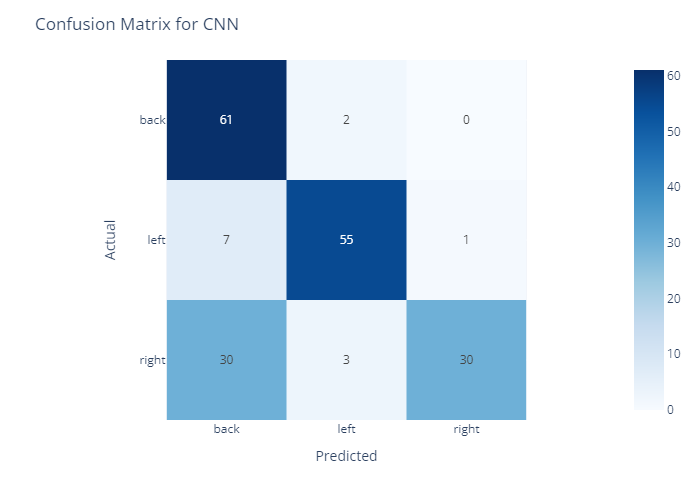

In [15]:
# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=y_total_max, predictions=y_pred_max).numpy()
# Create a dataframe from the confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, index=['back', 'left', 'right'], columns=['back', 'left', 'right'])
# Plot the confusion matrix
fig = px.imshow(confusion_matrix, color_continuous_scale='Blues', text_auto=True)
fig.update_layout(
    title='Confusion Matrix for CNN',
    xaxis_title='Predicted',
    yaxis_title='Actual',
)
fig.show(render_mode)

In [13]:
print(f'Accuracy: {np.sum(y_pred_max == y_total_max) / len(y_total_max)}')

Accuracy: 0.7724867724867724


In [14]:
model.save_weights('./checkpoints/my_checkpoint')
model.save('posture_classifer.keras')